# **First Steps: Road to the Top, Part 1**

This notebook has been prepared by me and is based on the fast.ai's Notebook, which can be found at the following link: https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1.

Review it for a comprehensive explanation.

## **Introduction**

In [1]:
creds = '{"username":"","key":""}'

In [2]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
!pip install fastkaggle

In [4]:
!pip install timm

In [5]:
from fastkaggle import *
import timm
from fastai.vision.all import *

In [6]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [7]:
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/sample_submission.csv')]

## **Looking at the data**

In [8]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


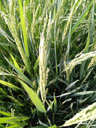

In [9]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

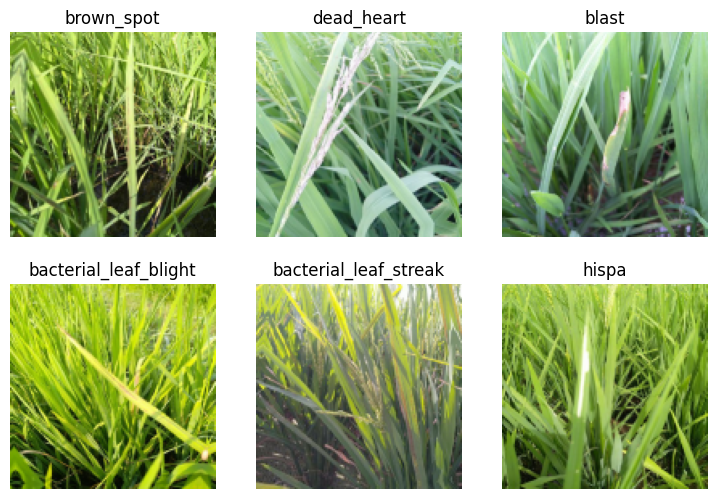

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## **Our first model**

In [12]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0010000000474974513, slide=0.001737800776027143)

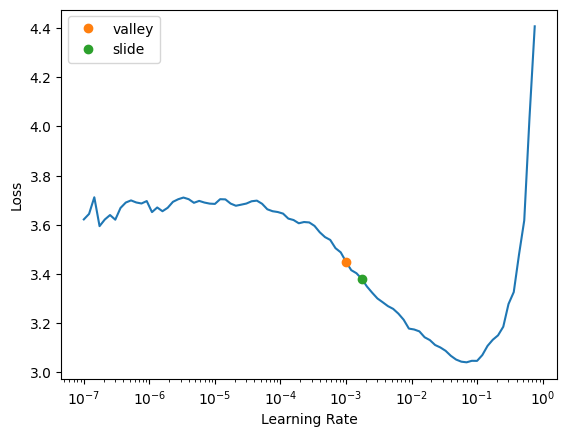

In [13]:
learn.lr_find(suggest_funcs=(valley, slide))

In [14]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.747051,1.209821,0.402210,01:38


epoch,train_loss,valid_loss,error_rate,time
0,1.141451,0.785291,0.254205,01:36
1,0.760626,0.472267,0.145603,01:36
2,0.544049,0.394855,0.121576,01:36


## **Submitting to Kaggle**

In [15]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [16]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [17]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 4,  ..., 8, 1, 5])

In [18]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [19]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [20]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,normal


In [21]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 70.1k/70.1k [00:03<00:00, 22.9kB/s]
